In [1]:
#### DO NOT RUN THIS CODE IN THE NOTEBOOK - copy paste into terminal in the HOME directory!

# git clone https://github.com/tensorflow/models.git

In [2]:
 # !pip install s3fs -q
 # !pip install tensorflow_hub -q
 # !pip install tensorflow_datasets -q
 # !pip install pycocotools -q
 # !pip install gin-config -q
 # !pip install immutabledict -q
 # !pip install sentencepiece -q
 # !pip install transformers -q
 # !pip install -r official/projects/movinet/requirements.txt -q

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import configparser

config = configparser.ConfigParser()
config.read('/home/ec2-user/.aws/credentials')

['/home/ec2-user/.aws/credentials']

In [5]:
# AWS credentials and S3 settings
aws_access_key_id = config["default"]['aws_access_key_id']
aws_secret_access_key = config["default"]['aws_secret_access_key']
bucket_name = 'asl-capstone'
s3_URI = 's3://asl-capstone/'

In [6]:
import s3fs
fs = s3fs.S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)

import boto3
s3 = boto3.client('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key,
                  region_name = 'us-west-2')


In [7]:
import tensorflow as tf, tf_keras
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import requests
from typing import List, Tuple
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')
tf.keras.backend.clear_session()

2023-11-28 23:45:24.450458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 23:45:26.304300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
%cd /home/ec2-user/models

/home/ec2-user/models


In [9]:
pwd

'/home/ec2-user/models'

In [10]:
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a3_base.tar.gz
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a5_base.tar.gz
# # !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a5_base_k400.tar.gz

# # !tar -xf movinet_a5_base_k400.tar.gz
# # !mv movinet_a5_base movinet_a5_base_k400
# # !tar -xf movinet_a0_base.tar.gz
# !tar -xf movinet_a3_base.tar.gz
# # !tar -xf movinet_a5_base.tar.gz

In [11]:
model_version = 'a2'

if model_version=='a3':
  max_frames = 120
  image_dims = (256,256)
elif model_version=='a2':
  max_frames = 80
  image_dims = (224,224)
elif model_version=='a0':
  max_frames = 50
  image_dims = (172,172)


from official.projects.movinet.modeling import movinet

if model_version == 'a3':
    from official.projects.movinet.modeling import movinet_model_a3_modified as movinet_model_modified
elif model_version == 'a2':
    from official.projects.movinet.modeling import movinet_model_a2_modified as movinet_model_modified


In [12]:
# # Get the kinetics-600 action labels
# KINETICS_URL = "official/projects/movinet/files/kinetics_600_labels.txt"
# with open(KINETICS_URL) as obj:
#   labels_600 = [line for line in obj.readlines()]
# print("Found %d labels." % len(labels_600))

In [13]:
# vid1 = pd.read_parquet('s3://asl-capstone/wlasl/video_mappings_masterfile.parquet', 
#                        columns=['word','rgb_path','padded_path'])


# vid2 = pd.read_parquet('s3://asl-capstone/msasl/video_mappings_masterfile.parquet')
# vid2 = vid2.rename(columns={'caption':'word', 'path':'rgb_path'})
# vid2['padded_path'] = vid2.rgb_path.replace('/RGB/', '/padded/')

# video_files = pd.concat([vid1, vid2], axis=0)

# label_nums = video_files.word.value_counts().reset_index().reset_index().rename(columns={'index':'label_num'})

# label_nums.to_parquet('s3://asl-capstone/movinet_word_labels.parquet')

# video_files = video_files.merge(label_nums, on='word')
# video_files = video_files.drop_duplicates()
# video_files['padded_path'] = video_files['padded_path'].str.replace('/RGB/', '/padded/')
# video_files.to_parquet('s3://asl-capstone/movinet_masterfile_mappings.parquet')

In [14]:
video_files = pd.read_parquet('s3://asl-capstone/movinet_masterfile_mappings.parquet')

In [15]:
display(video_files.head())
print(video_files.shape)
print(video_files.word.nunique())

# media.show_video(vid, codec='gif', fps=10)

,word,rgb_path,padded_path,label_num,count
0,viewpoint,asl-capstone/wlasl/RGB/viewpoint_0.npy,asl-capstone/wlasl/padded/viewpoint_0.npy,1387,5
1,viewpoint,asl-capstone/wlasl/RGB/viewpoint_1.npy,asl-capstone/wlasl/padded/viewpoint_1.npy,1387,5
2,viewpoint,asl-capstone/wlasl/RGB/viewpoint_2.npy,asl-capstone/wlasl/padded/viewpoint_2.npy,1387,5
3,viewpoint,asl-capstone/wlasl/RGB/viewpoint_3.npy,asl-capstone/wlasl/padded/viewpoint_3.npy,1387,5
4,viewpoint,asl-capstone/wlasl/RGB/viewpoint_4.npy,asl-capstone/wlasl/padded/viewpoint_4.npy,1387,5


(25479, 5)
1997


In [16]:
video_files['padded_path'] = video_files['padded_path'].str.replace('/RGB/', '/padded/')

In [17]:
video_files.word.value_counts()[:10]

word
africa       72
afternoon    70
afraid       54
again        45
accident     43
thin         36
before       36
adopt        36
tall         33
cousin       33
Name: count, dtype: int64

In [18]:
smaller_samples = video_files[video_files['count']<=50]
larger_samples = video_files[video_files['count']>50].groupby('word').sample(50)

video_files = pd.concat([smaller_samples,larger_samples])
video_files.word.value_counts()[:10]

word
afternoon    50
africa       50
afraid       50
again        45
accident     43
thin         36
adopt        36
before       36
tall         33
cousin       33
Name: count, dtype: int64

In [19]:
video_files[video_files['count'] >= 27].word.nunique()

107

In [20]:
# count = video_files.word.value_counts()[:200][-1]
# words = video_files.word.value_counts()[video_files.word.value_counts() >= count].reset_index()['word'].unique()

# video_files = video_files[video_files.word.isin(words)]

video_files = video_files[video_files['count'] >= 27]

video_files.shape

(3148, 5)

In [21]:
NUM_CLASSES = video_files.word.nunique()
NUM_CLASSES

107

In [22]:
# print(video_files['frame_count'].mean())
# print(video_files['frame_count'].median())
# print(video_files['frame_count'].max())

In [23]:
if model_version=='a2':
    video_files['padded_path'] = video_files['padded_path'].str.replace('/padded/', '/padded_a2/')

In [24]:
train_files, test_files = train_test_split(video_files, train_size=0.8)
print(train_files.shape)
print(test_files.shape)

(2518, 5)
(630, 5)


In [25]:
train_files['flip'] = False

bootstrap = train_files.groupby('word').sample(2)
bootstrap['flip'] = True

train_files = pd.concat([train_files, bootstrap]).sample(frac=1)
train_files.shape

(2732, 6)

In [26]:
def data_generator(file_paths_df, add_flip=False):
    for _, row in file_paths_df.iterrows():
        with fs.open(row['padded_path'], 'rb') as f:
            video = np.load(f) #[:max_frames]

        if add_flip:
            if row['flip']==True:
                video = np.flip(video, axis=2)

        # video = tf.convert_to_tensor(video)

        # if model_version=='a2':
        #     video = tf.image.resize(video, image_dims)

        label = tf.one_hot(row['label_num'], NUM_CLASSES)
        yield video, label


# Create TensorFlow Dataset for model input. 
train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(train_files, add_flip=True),
    output_signature=(
        tf.TensorSpec(shape=(max_frames, image_dims[0], image_dims[1], 3)),
        tf.TensorSpec(shape=(NUM_CLASSES), dtype=tf.int32)
    )
)

# Create TensorFlow Dataset for model input. 
test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(test_files),
    output_signature=(
        tf.TensorSpec(shape=(max_frames, image_dims[0], image_dims[1], 3)),
        tf.TensorSpec(shape=(NUM_CLASSES), dtype=tf.int32)
    )
)

2023-11-28 23:45:33.631602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 23:45:34.014672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 23:45:34.017039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [27]:
#next(iter(train_dataset.batch(1))) #Does a sanity check to confirm that the dataset is processed in batches

In [28]:
# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_version, #change to correspond to model
    causal=False,
    use_external_states=False,
)

In [29]:
def build_classifier(backbone, num_classes, encoder_dim=768, dropout_rate=0.05):
    """Builds a classifier on top of a backbone model."""
    model = movinet_model_modified.MovinetClassifier(
        backbone=backbone,
        num_classes=num_classes, 
        encoder_dim=encoder_dim, 
        dropout_rate=dropout_rate)
    model.build([2, max_frames, image_dims[0], image_dims[1], 3])

    model.layers[0].trainable = False
    model.layers[1].trainable = True
    model.layers[-1].trainable = True

    if model_version == 'a2':
        for i in range(21):
            model.layers[1].layers[i].trainable = False
    elif model_version == 'a3':
        for i in range(25):
            model.layers[1].layers[i].trainable = False

    model.layers[1].layers[-1].trainable = False

    return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.
model = build_classifier(backbone, NUM_CLASSES, encoder_dim=768, dropout_rate=0.05)

In [30]:
model.summary()

Model: "movinet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    2738754   
                             None, None, 16),                    
                              'block0_layer0': (None             
                             , None, None, None, 16)             
                             , 'block0_layer1': (Non             
                             e, None, None, None, 16             
                             ),                                  
                              'block0_layer2': (None             
                             , None, None, None, 16)             
                             , 'block1_layer0': 

In [31]:
for i in range(len(model.layers[1].layers)):
    print(model.layers[1].layers[i].name, i, model.layers[1].layers[i].trainable)

inputs 0 False
stem 1 False
block0_layer0 2 False
block0_layer1 3 False
block0_layer2 4 False
block1_layer0 5 False
block1_layer1 6 False
block1_layer2 7 False
block1_layer3 8 False
block1_layer4 9 False
block2_layer0 10 False
block2_layer1 11 False
block2_layer2 12 False
block2_layer3 13 False
block2_layer4 14 False
block3_layer0 15 False
block3_layer1 16 False
block3_layer2 17 False
block3_layer3 18 False
block3_layer4 19 False
block3_layer5 20 False
block4_layer0 21 True
block4_layer1 22 True
block4_layer2 23 True
block4_layer3 24 True
block4_layer4 25 True
block4_layer5 26 True
block4_layer6 27 True
head 28 False


In [49]:
NUM_EPOCHS = 2
BATCH_SIZE = 16

train_steps = len(train_files) // BATCH_SIZE
total_train_steps = train_steps * NUM_EPOCHS

test_steps = len(test_files) // BATCH_SIZE

loss_obj = tf_keras.losses.CategoricalCrossentropy(
    from_logits=True, #label_smoothing=0.05
    )

metrics = [
    tf_keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32),
    tf_keras.metrics.TopKCategoricalAccuracy(
        k=5, name='top_5', dtype=tf.float32),
]

initial_learning_rate = 0.001
learning_rate = tf_keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps, warmup_target=0.01, warmup_steps=50
)

optimizer = tf_keras.optimizers.RMSprop(learning_rate=learning_rate,
                                        rho=0.9, momentum=0.9, 
                                        epsilon=1.0, clipnorm=1.0)


model.compile(loss={'prediction':loss_obj, 'vid_embedding':None}, 
              optimizer=optimizer, 
              metrics={'prediction':metrics, 'vid_embedding':None})


# look into quantization for tf

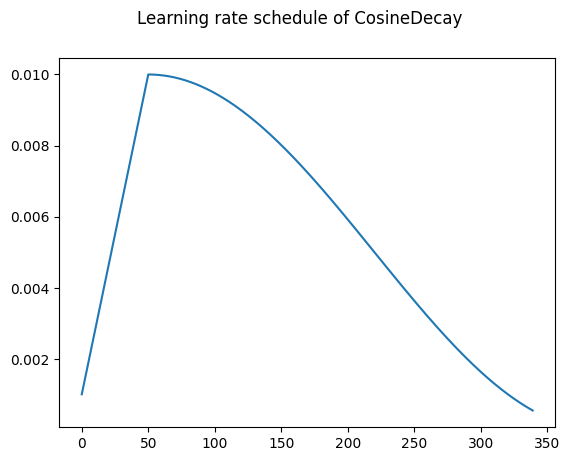

In [50]:
%matplotlib inline

def visualize_lr_schedule(opt, n_steps, step_s) -> Tuple[List[int], List[float]]:
    """Visualize tensorflow keras scheduler learning rate over the course of n_steps training steps.

    Args:
        opt (LearningRateSchedule): learning rate scheduler to be visualized.
        n_steps (int): number of training steps to visualize over.
        step_s (int): sampling step of the training steps, i.e. takes each step_s in the interval [0, n_steps].

    Returns:
        Tuple[List[int], List[float]]: returns x (steps), y (lr values) values of the plot.
    """
    lr = []
    steps = list(range(0, n_steps, step_s))

    for step in steps:
        lr_at_s = opt(step).numpy()
        lr.append(lr_at_s)

    plt.suptitle(f'Learning rate schedule of {type(opt).__name__}')
    plt.plot(steps, lr)

    return steps, lr


steps, lr_values = visualize_lr_schedule(learning_rate, n_steps=total_train_steps, step_s=1)

In [35]:
# takes about 5 mins from start to find out if this will fail or not
# got through 4 epochs in 12 minutes
results = model.fit(
                train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                validation_data=test_dataset.batch(BATCH_SIZE, drop_remainder=True),
                epochs=NUM_EPOCHS,
                verbose=1)


Epoch 1/2


2023-11-28 23:48:11.301633: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20b83ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 23:48:11.301679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-28 23:48:14.686334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-28 23:48:21.086940: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-28 23:48:55.171574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-28 23:48:56.356857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


    170/Unknown - 10512s 61s/step - loss: 6.1214 - classifier_head_loss: 6.1214 - classifier_head_top_1: 0.0099 - classifier_head_top_5: 0.0533

2023-11-29 02:42:23.747292: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15969740509382418904
2023-11-29 02:42:23.747609: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9486207515426799424


170/170 [==============================] - 12778s 75s/step - loss: 6.1214 - classifier_head_loss: 6.1214 - classifier_head_top_1: 0.0099 - classifier_head_top_5: 0.0533 - val_loss: 6.4611 - val_classifier_head_loss: 6.4611 - val_classifier_head_top_1: 0.0096 - val_classifier_head_top_5: 0.0529
Epoch 2/2


2023-11-29 03:19:26.923475: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11274507339056449989
2023-11-29 03:19:26.923679: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10111565612499979319


170/170 [==============================] - 12454s 73s/step - loss: 4.9298 - classifier_head_loss: 4.9298 - classifier_head_top_1: 0.0140 - classifier_head_top_5: 0.0768 - val_loss: 4.6845 - val_classifier_head_loss: 4.6845 - val_classifier_head_top_1: 0.0272 - val_classifier_head_top_5: 0.1010


In [40]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                validation_data=test_dataset.batch(BATCH_SIZE, drop_remainder=True),
                epochs=NUM_EPOCHS,
                verbose=1)


Epoch 1/2
    170/Unknown - 10472s 61s/step - loss: 4.7070 - classifier_head_loss: 4.7070 - classifier_head_top_1: 0.0415 - classifier_head_top_5: 0.1312

2023-11-29 09:47:10.283198: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15969740509382418904
2023-11-29 09:47:10.283425: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9486207515426799424


170/170 [==============================] - 12828s 75s/step - loss: 4.7070 - classifier_head_loss: 4.7070 - classifier_head_top_1: 0.0415 - classifier_head_top_5: 0.1312 - val_loss: 4.8420 - val_classifier_head_loss: 4.8420 - val_classifier_head_top_1: 0.0144 - val_classifier_head_top_5: 0.0609
Epoch 2/2


2023-11-29 10:25:44.980384: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11274507339056449989
2023-11-29 10:25:44.980558: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10111565612499979319


170/170 [==============================] - 11398s 67s/step - loss: 4.2032 - classifier_head_loss: 4.2032 - classifier_head_top_1: 0.1165 - classifier_head_top_5: 0.2548 - val_loss: 4.3741 - val_classifier_head_loss: 4.3741 - val_classifier_head_top_1: 0.0994 - val_classifier_head_top_5: 0.2115


In [41]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2')

INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2/assets


INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2/assets


In [42]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_a2_epoch4_finetuned.h5')

In [43]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                validation_data=test_dataset.batch(BATCH_SIZE, drop_remainder=True),
                epochs=NUM_EPOCHS,
                verbose=1)

Epoch 1/2
    170/Unknown - 9455s 56s/step - loss: 3.7181 - classifier_head_loss: 3.7181 - classifier_head_top_1: 0.1926 - classifier_head_top_5: 0.3864

2023-11-29 16:16:04.220702: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15969740509382418904
2023-11-29 16:16:04.220958: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9486207515426799424


170/170 [==============================] - 11817s 70s/step - loss: 3.7181 - classifier_head_loss: 3.7181 - classifier_head_top_1: 0.1926 - classifier_head_top_5: 0.3864 - val_loss: 4.3729 - val_classifier_head_loss: 4.3729 - val_classifier_head_top_1: 0.1042 - val_classifier_head_top_5: 0.2260
Epoch 2/2


2023-11-29 16:54:39.697356: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11274507339056449989
2023-11-29 16:54:39.697531: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10111565612499979319


170/170 [==============================] - 11871s 70s/step - loss: 3.7147 - classifier_head_loss: 3.7147 - classifier_head_top_1: 0.1952 - classifier_head_top_5: 0.3879 - val_loss: 4.3768 - val_classifier_head_loss: 4.3768 - val_classifier_head_top_1: 0.1042 - val_classifier_head_top_5: 0.2244


In [44]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_a2_epoch6_finetuned.h5')
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2')

INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2/assets


INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2/assets


In [52]:
for i in range(15,21):
    model.layers[1].layers[i].trainable = True

for i in range(21,len(model.layers[1].layers)):
    model.layers[1].layers[i].trainable = False

for i in range(len(model.layers[1].layers)):
    print(model.layers[1].layers[i].name, i, model.layers[1].layers[i].trainable)

inputs 0 False
stem 1 False
block0_layer0 2 False
block0_layer1 3 False
block0_layer2 4 False
block1_layer0 5 False
block1_layer1 6 False
block1_layer2 7 False
block1_layer3 8 False
block1_layer4 9 False
block2_layer0 10 False
block2_layer1 11 False
block2_layer2 12 False
block2_layer3 13 False
block2_layer4 14 False
block3_layer0 15 True
block3_layer1 16 True
block3_layer2 17 True
block3_layer3 18 True
block3_layer4 19 True
block3_layer5 20 True
block4_layer0 21 False
block4_layer1 22 False
block4_layer2 23 False
block4_layer3 24 False
block4_layer4 25 False
block4_layer5 26 False
block4_layer6 27 False
head 28 False


In [53]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                validation_data=test_dataset.batch(BATCH_SIZE, drop_remainder=True),
                epochs=NUM_EPOCHS,
                verbose=1)

Epoch 1/2
    170/Unknown - 10055s 59s/step - loss: 3.4783 - classifier_head_loss: 3.4783 - classifier_head_top_1: 0.2379 - classifier_head_top_5: 0.4368

2023-11-30 01:27:31.178009: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15969740509382418904
2023-11-30 01:27:31.178297: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9486207515426799424


170/170 [==============================] - 12356s 73s/step - loss: 3.4783 - classifier_head_loss: 3.4783 - classifier_head_top_1: 0.2379 - classifier_head_top_5: 0.4368 - val_loss: 4.2938 - val_classifier_head_loss: 4.2938 - val_classifier_head_top_1: 0.1442 - val_classifier_head_top_5: 0.2837
Epoch 2/2


2023-11-30 02:05:06.843843: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 11274507339056449989
2023-11-30 02:05:06.844092: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10111565612499979319


KeyboardInterrupt: 

In [54]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_a2_epoch8_finetuned.h5')
# model.save('/home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2')

inputs 0 False
stem 1 False
block0_layer0 2 False
block0_layer1 3 False
block0_layer2 4 False
block1_layer0 5 False
block1_layer1 6 False
block1_layer2 7 False
block1_layer3 8 False
block1_layer4 9 False
block2_layer0 10 False
block2_layer1 11 False
block2_layer2 12 False
block2_layer3 13 False
block2_layer4 14 False
block3_layer0 15 False
block3_layer1 16 False
block3_layer2 17 False
block3_layer3 18 False
block3_layer4 19 False
block3_layer5 20 False
block4_layer0 21 True
block4_layer1 22 True
block4_layer2 23 True
block4_layer3 24 True
block4_layer4 25 True
block4_layer5 26 True
block4_layer6 27 True
head 28 False


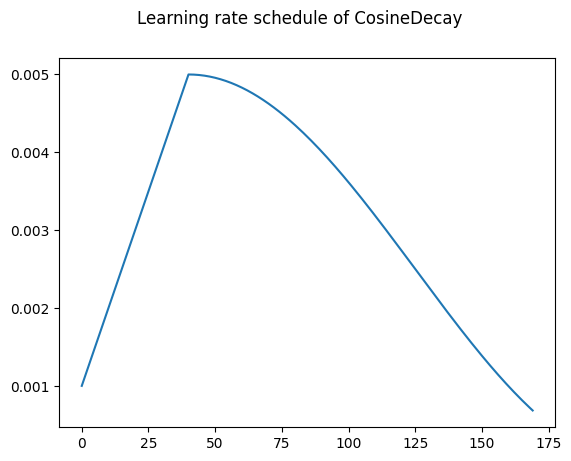

In [57]:
model.layers[1].trainable = True

for i in range(21):
            model.layers[1].layers[i].trainable = False

model.layers[1].layers[-1].trainable = False

for i in range(len(model.layers[1].layers)):
    print(model.layers[1].layers[i].name, i, model.layers[1].layers[i].trainable)


NUM_EPOCHS = 1
BATCH_SIZE = 16

train_steps = len(train_files) // BATCH_SIZE
total_train_steps = train_steps * NUM_EPOCHS

test_steps = len(test_files) // BATCH_SIZE

initial_learning_rate = 0.001
learning_rate = tf_keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps, warmup_target=0.005, warmup_steps=40
)

optimizer = tf_keras.optimizers.RMSprop(learning_rate=learning_rate,
                                        rho=0.9, momentum=0.9, 
                                        epsilon=1.0, clipnorm=1.0)

model.compile(loss={'prediction':loss_obj, 'vid_embedding':None}, 
              optimizer=optimizer, 
              metrics={'prediction':metrics, 'vid_embedding':None})

steps, lr_values = visualize_lr_schedule(learning_rate, n_steps=total_train_steps, step_s=1)

In [58]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                validation_data=test_dataset.batch(BATCH_SIZE, drop_remainder=True),
                epochs=NUM_EPOCHS,
                verbose=1)

    170/Unknown - 9877s 58s/step - loss: 3.2136 - classifier_head_loss: 3.2136 - classifier_head_classifier_head_top_1: 0.2840 - classifier_head_classifier_head_top_5: 0.4971

2023-11-30 04:53:28.793632: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15969740509382418904
2023-11-30 04:53:28.793902: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9486207515426799424


170/170 [==============================] - 12093s 71s/step - loss: 3.2136 - classifier_head_loss: 3.2136 - classifier_head_classifier_head_top_1: 0.2840 - classifier_head_classifier_head_top_5: 0.4971 - val_loss: 4.3029 - val_classifier_head_loss: 4.3029 - val_classifier_head_classifier_head_top_1: 0.1651 - val_classifier_head_classifier_head_top_5: 0.2885


In [59]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_a2_epoch9_finetuned.h5')

In [82]:
model.export('/home/ec2-user/ASL-Translator/modeling/movinet_export')

INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_export/assets


INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_export/assets


Saved artifact at '/home/ec2-user/ASL-Translator/modeling/movinet_export'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, None, None, None, 3)
  Returns:
    {'prediction': <1>, 'vid_embedding': <2>}
      <1>: float32 Tensor, shape=(None, 107)
      <2>: float32 Tensor, shape=(None, None, 768)


In [78]:
model.save('/home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2_epoch9.keras')

In [68]:
test = model(tf.random.uniform((3,14,224,224,3)))['vid_embedding']

In [85]:
model.backbone.save('/home/ec2-user/ASL-Translator/modeling/movinet_a2_backbone_finetuned_saved')

INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_a2_backbone_finetuned_saved/assets


INFO:tensorflow:Assets written to: /home/ec2-user/ASL-Translator/modeling/movinet_a2_backbone_finetuned_saved/assets


In [84]:
# tf_keras.models.save_model(model, '/home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2_epoch9')

# model_test = tf.keras.models.load_model('/home/ec2-user/ASL-Translator/modeling/movinet_a2_epoch9_finetuned.h5')

checkpoint = tf.train.Checkpoint(model.backbone)

# Save a checkpoint to /tmp/training_checkpoints-{save_counter}. Every time
# checkpoint.save is called, the save counter is increased.
save_path = checkpoint.save('/home/ec2-user/ASL-Translator/modeling/movinet_a2_backbone_finetuned')



In [72]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2_epoch9') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/home/ec2-user/ASL-Translator/modeling/movinet_a2_epoch9.tflite', 'wb') as f:
  f.write(tflite_model)


2023-11-30 06:09:11.007885: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-30 06:09:11.007933: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-30 06:09:11.008168: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2_epoch9
2023-11-30 06:09:11.177336: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-30 06:09:11.177378: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /home/ec2-user/ASL-Translator/modeling/movinet_checkpoints_a2_epoch9
2023-11-30 06:09:11.546193: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-30 06:09:12.901911: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /home/ec2-user/ASL-Translator/modeling/movinet_checkp

ConverterError: <unknown>:0: error: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block0_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.AvgPool3D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block0_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block1_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.AvgPool3D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block1_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block2_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.AvgPool3D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block2_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block4_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.AvgPool3D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["AvgPool3D:", "movinet_classifier/movinet/block4_layer0/bneck/skip/skip_pool/AvgPool3D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Conv2D:", "movinet_classifier/classifier_head/conv2d/Conv2D/Conv2D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.Conv2D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "movinet_classifier/classifier_head/conv2d/Conv2D/Conv2D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: loc(callsite(callsite(fused["Conv2D:", "movinet_classifier/classifier_head/conv2d_1/Conv2D/Conv2D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.Conv2D' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["Conv2D:", "movinet_classifier/classifier_head/conv2d_1/Conv2D/Conv2D@__inference__wrapped_model_1108511"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_1147287"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_FLEX_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops are not supported by the native TFLite runtime, you can enable TF kernels fallback using TF Select. See instructions: https://www.tensorflow.org/lite/guide/ops_select 
TF Select ops: AvgPool3D, Conv2D
Details:
	tf.AvgPool3D(tensor<?x?x?x?x16xf32>) -> (tensor<?x?x?x?x16xf32>) : {data_format = "NDHWC", device = "", ksize = [1, 1, 3, 3, 1], padding = "SAME", strides = [1, 1, 2, 2, 1]}
	tf.AvgPool3D(tensor<?x?x?x?x40xf32>) -> (tensor<?x?x?x?x40xf32>) : {data_format = "NDHWC", device = "", ksize = [1, 1, 3, 3, 1], padding = "SAME", strides = [1, 1, 2, 2, 1]}
	tf.AvgPool3D(tensor<?x?x?x?x72xf32>) -> (tensor<?x?x?x?x72xf32>) : {data_format = "NDHWC", device = "", ksize = [1, 1, 3, 3, 1], padding = "SAME", strides = [1, 1, 2, 2, 1]}
	tf.Conv2D(tensor<?x?x?x?xf32>, tensor<2x2x144x96xf32>) -> (tensor<?x?x?x96xf32>) : {data_format = "NHWC", device = "", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "VALID", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}
	tf.Conv2D(tensor<?x?x?x?xf32>, tensor<3x3x96x48xf32>) -> (tensor<?x?x?x48xf32>) : {data_format = "NHWC", device = "", dilations = [1, 1, 1, 1], explicit_paddings = [], padding = "VALID", strides = [1, 1, 1, 1], use_cudnn_on_gpu = true}



In [64]:
for i in range(10,16):
    model.layers[1].layers[i].trainable = True

for i in range(16,len(model.layers[1].layers)):
    model.layers[1].layers[i].trainable = False

for i in range(len(model.layers[1].layers)):
    print(model.layers[1].layers[i].name, i, model.layers[1].layers[i].trainable)


initial_learning_rate = 0.003
# learning_rate = tf_keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=total_train_steps, warmup_target=0.004, warmup_steps=80
# )
learning_rate = initial_learning_rate
optimizer = tf_keras.optimizers.RMSprop(learning_rate=learning_rate,
                                        rho=0.9, momentum=0.9, 
                                        epsilon=1.0, clipnorm=1.0)

model.compile(loss={'prediction':loss_obj, 'vid_embedding':None}, 
              optimizer=optimizer, 
              metrics={'prediction':metrics, 'vid_embedding':None})

# steps, lr_values = visualize_lr_schedule(learning_rate, n_steps=total_train_steps, step_s=1)

inputs 0 False
stem 1 False
block0_layer0 2 False
block0_layer1 3 False
block0_layer2 4 False
block1_layer0 5 False
block1_layer1 6 False
block1_layer2 7 False
block1_layer3 8 False
block1_layer4 9 False
block2_layer0 10 True
block2_layer1 11 True
block2_layer2 12 True
block2_layer3 13 True
block2_layer4 14 True
block3_layer0 15 True
block3_layer1 16 False
block3_layer2 17 False
block3_layer3 18 False
block3_layer4 19 False
block3_layer5 20 False
block4_layer0 21 False
block4_layer1 22 False
block4_layer2 23 False
block4_layer3 24 False
block4_layer4 25 False
block4_layer5 26 False
block4_layer6 27 False
head 28 False


In [65]:
results = model.fit(
                train_dataset.batch(BATCH_SIZE, drop_remainder=True),
                validation_data=test_dataset.batch(BATCH_SIZE, drop_remainder=True),
                epochs=NUM_EPOCHS,
                verbose=1)

2023-11-30 05:39:53.798142: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 229.69MiB (rounded to 240844800)requested by op 
2023-11-30 05:39:53.798241: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-11-30 05:39:53.798251: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 1109, Chunks in use: 1109. 277.2KiB allocated for chunks. 277.2KiB in use in bin. 22.8KiB client-requested in use in bin.
2023-11-30 05:39:53.798257: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 478, Chunks in use: 475. 300.8KiB allocated for chunks. 299.2KiB in use in bin. 225.6KiB client-requested in use in bin.
2023-11-30 05:39:53.798262: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (1024): 	Total Chunks: 277, Chunks in use: 275. 339.5KiB allocated for chunks. 336.8KiB in use in bin. 315.2KiB client-requested in use in bin.
2023-11-30 05:39:53.798268: 

ResourceExhaustedError: Graph execution error:

Detected at node 'movinet_classifier/movinet/block3_layer3/bneck/feature/conv3d/StatefulPartitionedCall' defined at (most recent call last):
    File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance
      app.start()
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 737, in start
      self.io_loop.start()
    File "/opt/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell
      await result
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "/opt/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "/opt/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "/opt/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5308/740136616.py", line 1, in <module>
      results = model.fit(
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1804, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function
      return step_function(self, iterator)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step
      outputs = model.train_step(data)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step
      y_pred = self(x, training=True)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 588, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__
      if _in_functional_construction_mode(
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_file6pg_6o_7.py", line 34, in error_handler
      retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 514, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 661, in _run_internal_graph
      for depth in depth_keys:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph
      for node in nodes:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph
      for node in nodes:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph
      for node in nodes:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 588, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__
      if _in_functional_construction_mode(
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_file6pg_6o_7.py", line 34, in error_handler
      retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 514, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 661, in _run_internal_graph
      for depth in depth_keys:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph
      for node in nodes:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph
      for node in nodes:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 663, in _run_internal_graph
      for node in nodes:
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__
      if _in_functional_construction_mode(
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_file6pg_6o_7.py", line 34, in error_handler
      retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/home/ec2-user/models/official/projects/movinet/modeling/movinet_layers.py", line 1255, in call
      return self._mobile_bottleneck(inputs, states=states)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__
      if _in_functional_construction_mode(
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_file6pg_6o_7.py", line 34, in error_handler
      retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/home/ec2-user/models/official/projects/movinet/modeling/movinet_layers.py", line 912, in call
      x, states = self._feature_layer(x, states=states)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__
      if _in_functional_construction_mode(
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_file6pg_6o_7.py", line 34, in error_handler
      retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/home/ec2-user/models/official/projects/movinet/modeling/movinet_layers.py", line 666, in call
      x = self._conv(x)
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 993, in error_handler
      def __call__(self, *args, **kwargs):
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 998, in error_handler
      **kwargs: Keyword arguments to be passed to `self.call`.
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1047, in __call__
      if _in_functional_construction_mode(
    File "/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_file6pg_6o_7.py", line 34, in error_handler
      retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/home/ec2-user/models/official/vision/modeling/layers/nn_layers.py", line 1054, in call
      return conv_fn(inputs)
Node: 'movinet_classifier/movinet/block3_layer3/bneck/feature/conv3d/StatefulPartitionedCall'
Out of memory while trying to allocate 240844800 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  229.71MiB
              constant allocation:         0B
        maybe_live_out allocation:  459.40MiB
     preallocated temp allocation:  229.71MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  689.11MiB
              total fragmentation:       136B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 229.69MiB
		Operator: op_type="Conv3D" op_name="PartitionedCall/Conv3D" source_file="/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/layers/convolutional/base_conv.py" source_line=268
		XLA Label: custom-call
		Shape: f32[16,240,80,14,14]
		==========================

	Buffer 2:
		Size: 229.69MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: transpose
		Shape: f32[16,80,14,14,240]
		==========================

	Buffer 3:
		Size: 229.69MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[16,80,14,14,240]
		==========================

	Buffer 4:
		Size: 25.3KiB
		Operator: op_name="XLA_Args"
		XLA Label: transpose
		Shape: f32[240,1,3,3,3]
		==========================

	Buffer 5:
		Size: 25.3KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,3,1,240]
		==========================

	Buffer 6:
		Size: 24B
		XLA Label: tuple
		Shape: (f32[16,80,14,14,240], f32[16,80,14,14,240], f32[3,3,3,1,240])
		==========================

	Buffer 7:
		Size: 16B
		Operator: op_type="Conv3D" op_name="PartitionedCall/Conv3D" source_file="/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/layers/convolutional/base_conv.py" source_line=268
		XLA Label: custom-call
		Shape: (f32[16,240,80,14,14], u8[0])
		==========================


	 [[{{node movinet_classifier/movinet/block3_layer3/bneck/feature/conv3d/StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_785501]

ea8f00 of size 2048 next 2707
2023-11-30 05:39:53.862646: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadacea9700 of size 768 next 2708
2023-11-30 05:39:53.862650: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadacea9a00 of size 768 next 2709
2023-11-30 05:39:53.862654: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadacea9d00 of size 2048 next 2710
2023-11-30 05:39:53.862658: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadaceaa500 of size 1536 next 2711
2023-11-30 05:39:53.862661: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadaceaab00 of size 2048 next 2712
2023-11-30 05:39:53.862665: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadaceab300 of size 1536 next 2713
2023-11-30 05:39:53.862669: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadaceab900 of size 768 next 2714
2023-11-30 05:39:53.862673: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7fadaceabc00 of size 768 

# Shut Down Instance

In [ ]:
def get_instance_id():
    """Get current instance ID from metadata"""
    url = "http://169.254.169.254/latest/meta-data/instance-id"
    response = requests.get(url)
    return response.text

def stop_instance(instance_id, region_name='us-west-2'):
    """Stop the EC2 instance"""
    ec2 = boto3.client('ec2', aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key, region_name=region_name)
    ec2.stop_instances(InstanceIds=[instance_id])

In [ ]:
# Get the current instance ID
instance_id = get_instance_id()
print(instance_id)
# Stop the instance
stop_instance(instance_id)